# Bayesian Experimental Design for model selection

Script used to perform optimisation where a 4 step experiment is being design considering only the Bhattacharyya distance of RFP for the two models

   ............................................................................................................................................................................................................................................

### Import Required libraries

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
from numba import jit
import gaussianprocess as gp
from fitderiv import fitderiv
import genutils as gu
import datetime
from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs
import pickle

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import math


### Model 1 Functions (ODEs, Steady State and Event based representation)
* Lugagne et. al. Model

In [2]:
@jit
def model1(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_in_IPTG = p[0]
    k_out_IPTG = p[1]
    k_in_aTc = p[2]
    k_out_aTc = p[3]
    k_L_pm0 = p[4]
    k_L_pm = p[5]
    theta_T = p[6]
    theta_aTc = p[7]
    n_aTc = p[8]
    n_T = p[9];
    k_T_pm0 = p[10]
    k_T_pm = p[11]
    theta_L = p[12]
    theta_IPTG = p[13]
    n_IPTG = p[14]
    n_L = p[15]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    
    if u_IPTG > y[0]:
        dInd_dt[0]=k_in_IPTG*(u_IPTG-y[0])
    else:
        dInd_dt[0]=k_out_IPTG*(u_IPTG-y[0])
    
    if u_aTc > y[2]:
        dInd_dt[1]=k_in_aTc*(u_aTc-y[1])
    else:
        dInd_dt[1]=k_out_aTc*(u_aTc-y[1])
    
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState1(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_in_IPTG = p[0]
    k_out_IPTG = p[1]
    k_in_aTc = p[2]
    k_out_aTc = p[3]
    k_L_pm0 = p[4]
    k_L_pm = p[5]
    theta_T = p[6]
    theta_aTc = p[7]
    n_aTc = p[8]
    n_T = p[9];
    k_T_pm0 = p[10]
    k_T_pm = p[11]
    theta_L = p[12]
    theta_IPTG = p[13]
    n_IPTG = p[14]
    n_L = p[15]
    
    # ODEs steady state equations
    alpha = np.empty(2)
    alpha[0] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(u_aTc/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[1] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(u_IPTG/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode1(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    Y0 = np.empty(4)
    
    y_al = SteadyState1(p,ivss) # Calculation of initial guesses for steady state
    Y0[0] = pre[0]
    Y0[1] = pre[1]
    Y0[2] = y_al[0]
    Y0[3] = y_al[1]
    ssv = odeint(model1,Y0,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model1,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model1,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]

    return(final)



### Model 2 Functions (ODEs, Steady State and Event based representation)
* Intermediate Model (Single rate, no degradation)

In [3]:
@jit
def model2(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    dInd_dt[0] = k_IPTG*(u_IPTG-y[0]);
    dInd_dt[1] = k_aTc*(u_aTc-y[1]);
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState2(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs steady state equations
    alpha = np.empty(2)
    alpha[0] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(u_aTc/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[1] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(u_IPTG/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode2(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    Y0 = np.empty(4)
    
    y_al = SteadyState2(p,ivss) # Calculation of initial guesses for steady state
    Y0[0] = pre[0]
    Y0[1] = pre[1]
    Y0[2] = y_al[0]
    Y0[3] = y_al[1]
    ssv = odeint(model2,Y0,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model2,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model2,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]

    return(final)



### Model 3 Functions (ODEs, Steady State and Event based representation)
* Lucia's Model

In [4]:
@jit
def model3(y,t,p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs
    dInd_dt = np.empty(4).tolist()
    dInd_dt[0] = k_IPTG*(u_IPTG-y[0])-0.0165*y[0];
    dInd_dt[1] = k_aTc*(u_aTc-y[1])-0.0165*y[1];
    dInd_dt[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+(y[3]/theta_T*1/(1+(y[1]/theta_aTc)**n_aTc))**n_T))))-0.0165*y[2];
    dInd_dt[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+(y[2]/theta_L*1/(1+(y[0]/theta_IPTG)**n_IPTG))**n_L))))-0.0165*y[3];
    
    # Results
    return dInd_dt

def SteadyState3(p,I):
    
    # Inputs
    u_IPTG = I[0]
    u_aTc = I[1]
    preRFP = I[2]
    preGFP = I[3]
    
    # Parameters
    k_IPTG = p[0]
    k_aTc = p[1]
    k_L_pm0 = p[2]
    k_L_pm = p[3]
    theta_T = p[4]
    theta_aTc = p[5]
    n_aTc = p[6]
    n_T = p[7];
    k_T_pm0 = p[8]
    k_T_pm = p[9]
    theta_L = p[10]
    theta_IPTG = p[11]
    n_IPTG = p[12]
    n_L = p[13]
    
    # ODEs steady state equations
    alpha = np.empty(4)
    alpha[0] = (k_IPTG*u_IPTG)/(k_IPTG+0.0165)
    alpha[1] = (k_aTc*u_aTc)/(k_aTc+0.0165)
    alpha[2] = ((1/0.1386)*(k_L_pm0+(k_L_pm/(1+((preGFP/theta_T)*1/(1+(alpha[1]/theta_aTc)**n_aTc))**n_T))))/0.0165
    alpha[3] = ((1/0.1386)*(k_T_pm0+(k_T_pm/(1+((preRFP/theta_L)*1/(1+(alpha[0]/theta_IPTG)**n_IPTG))**n_L))))/0.0165
    
    # Results
    return alpha


def solve_coupled_ode3(ts, p, sp, inputs, ivss, pre):
    maxtime = len(ts);
    Nsp = len(sp);
    Nevents = len(sp)-1;
    Neq = 4;
    p = p
    
    final = np.zeros((maxtime,Neq))
    
    y_al = SteadyState3(p,ivss) # Calculation of initial guesses for steady state
    
    ssv = odeint(model3,y_al,np.linspace(0,24*60,(24*60)+1),args=(p,pre), rtol=1e-9,atol=1e-9, tcrit=np.array(range(0,24*60+1)))
    
    y0 = ssv[24*60,:]
    
    initialV = y0
    i = 0
    
    for q in range(0,Nevents):
        
        lts = len(ts[(sp[q]+1):sp[q+1]+1])  # General way to define the number of elements in each event series
        Tevent = ts[(sp[q]):sp[q+1]+1]  # General way to extract the times of each event
        I = inputs[i:(i+2)]
        
        if q == 0:
            
            part1 = odeint(model3,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))#, full_output =1)
            
        else:
            
            part1 = odeint(model3,initialV,ts[(sp[q]):sp[q+1]+1],args=(p,I), 
                         rtol=1e-9,atol=1e-9, tcrit=np.array(range((sp[q]),sp[q+1])))
        
        initialV = part1[lts]
        i=i+2;
        
        for d in range((sp[q]),(sp[q]+lts+1)):
            
            final[d,:] = part1[d-sp[q]]
        
        
        
    
    return(final)

### Functions to simulate the 3 models for all parameter draws

In [5]:
def solveALL (ts, pD, sp, inputs, ivss, pre, model):
    
    AllSol = np.empty((len(ts),len(pD[:,1])*2))
    AllSolTest = np.empty(((round(len(ts)/5)+1),len(pD[:,1])*2))
    for drawInd in range(0,len(pD[:,1])):
        
        p = pD[drawInd,:]
        if model == 'M1':
            temp = solve_coupled_ode1(ts, p, sp, inputs, ivss, pre)
        elif model == 'M2':
            temp = solve_coupled_ode2(ts, p, sp, inputs, ivss, pre)
        elif model == 'M3':
            temp = solve_coupled_ode3(ts, p, sp, inputs, ivss, pre)
        else:
            print('Please, select a correct model as M1, M2 or M3 for the desired one')

        AllSolTest[:,drawInd] = temp[:,2][::5]
        AllSolTest[:,drawInd+(len(pD[:,1]))] = temp[:,3][::5]

    return(AllSolTest)
    

### Example:

In [6]:
ivss = [1,1e-7,1363.193,28.510]
pre = [1,1e-7]
inputs = np.empty(18) # What needs to be optimised    --> example: [1e-7,100,1,1e-7]*4+[1e-7,100]
evnT = [int(i) for i in list(np.linspace(0,(24*60),10))]
t = np.linspace(0,(24*60),(24*60)+1)
pM3 = np.asarray(pd.read_csv("ParametersCSV/draws_ALL_Model3.stan.csv"))

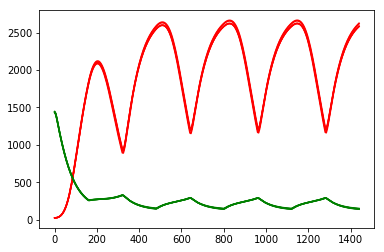

In [7]:
p = pM3[0:5,:]
test = solveALL(t,p,evnT,[1e-7,100,1,1e-7]*4+[1e-7,100],ivss,pre, 'M3')
plt.figure()
plt.plot(t[::5], test[:,0:5], 'r')
plt.plot(t[::5], test[:,5:10], 'g')
plt.show()

### Bhattacharyya distance function:

In [8]:

def BhattacharyyaDist (mu1, mu2, sd1, sd2):
    E = (sd1+sd2)/2
    Em1 = np.linalg.inv(E)
    dE = abs(np.linalg.det(E))

    t1 = np.matrix.transpose((np.matrix.transpose(np.matrix(mu1))-np.matrix.transpose(np.matrix(mu2))))
    t2 = np.matrix.transpose(np.matrix(mu1))-np.matrix.transpose(np.matrix(mu2))
    
    ft = (1/8)*t1*Em1*t2
    st = dE/np.sqrt(abs(np.linalg.det(sd1))*abs(np.linalg.det(sd2)))
    
    bhd = ft+0.5*np.log(st)
    
    return(float(bhd))



### Definition of the utility function:

In [9]:

def utility2 (IPTG1, IPTG2, IPTG3, IPTG4,
             aTc1, aTc2, aTc3, aTc4):
    
    # Definition of inputs for the ODEs
        
    inputs = [round(IPTG1,2)+1e-7, int(aTc1)+1e-7, round(IPTG2,2)+1e-7, int(aTc2)+1e-7,
              round(IPTG3,2)+1e-7, int(aTc3)+1e-7, round(IPTG4,2)+1e-7, int(aTc4)+1e-7]
    
    # Initial values for steady state and inputs
    ivss = [1,1e-7,1363.193,28.510]
    pre = [1,1e-7]
    # Event switches and inputs
    sp = [int(i) for i in list(np.linspace(0,(24*60),5))]
    t =  np.linspace(0,(24*60),(24*60)+1)
    
    # load parameter draws for the two models
    pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
    pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))
    
    # Simulation of the system for the two models and extract of results
    solM1 = solveALL(t, pM1, sp, inputs, ivss, pre, 'M1')
    solM2 = solveALL(t, pM2, sp, inputs, ivss, pre, 'M2')
    
    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]
    
    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]
    
    # Gaussian Process Regression and Reduction
    
    # Means and standard deviations for each time point for each species and for each model
    tgp = np.linspace(0,(24*60),round(24*60/5)+1)
    
    muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
    sdR3 = RFP_M2.std(axis = 1)
#     muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
#     sdG3 = GFP_M2.std(axis = 1)
    muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
    sdR2 = RFP_M1.std(axis = 1)
#     muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
#     sdG2 = GFP_M1.std(axis = 1)

    # Gaussian Process regression
    gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
    gR3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR3.predict(tgp)
    
#     gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
#     gG3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
#     gG3.predict(tgp)
    
    gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
    gR2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR2.predict(tgp)
    
#     gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
#     gG2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
#     gG2.predict(tgp)
    
    # Time points reduction

    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R2.predict(tref)

    
#     muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
#     tref = list(tgp[::10])

#     g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
#     g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
#     g2G3.predict(tref)

    
#     muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
#     tref = list(tgp[::10])

    
#     g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
#     g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
#     g2G2.predict(tref)

    
    # Bhattacharyya distance:
    bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
#     bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    # Utility function value
    u_B = (bdR)

    return(u_B)
    


### Bayesian Optimisation: 

In [10]:
# Bounded region of parameter space

pbounds = {'IPTG1': (0, 1), 'IPTG2': (0, 1), 'IPTG3': (0, 1), 'IPTG4': (0, 1),
           'aTc1': (0, 100), 'aTc2': (0, 100), 'aTc3': (0, 100), 'aTc4': (0, 100)}


Setting Bayesian Optimisation with our utility function

In [11]:
optimizer3 = BayesianOptimization(
    f=utility2,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1324,
) 

Begin optimisation rutine

In [30]:
optimizer3.maximize(
    init_points=0,
    n_iter=200,
    alpha=1e-2,
    n_restarts_optimizer=3, 
#     acq="ei", 
#     xi=1e-4
)

|   iter    |  target   |   IPTG1   |   IPTG2   |   IPTG3   |   IPTG4   |   aTc1    |   aTc2    |   aTc3    |   aTc4    |
-------------------------------------------------------------------------------------------------------------------------
|  805      |  2.918e+0 |  0.473    |  0.8115   |  0.7736   |  0.8725   |  11.67    |  49.36    |  4.449    |  29.97    |
|  806      |  1.122e+0 |  0.3001   |  0.3878   |  0.7348   |  0.522    |  33.8     |  76.34    |  62.63    |  17.76    |
|  807      |  2.89e+03 |  0.518    |  0.339    |  0.3266   |  0.2412   |  88.81    |  2.902    |  36.3     |  85.13    |
|  808      |  1.99e+03 |  0.3469   |  0.1658   |  0.8415   |  0.07134  |  99.62    |  16.58    |  61.22    |  4.504    |
|  809      |  2.794e+0 |  0.06718  |  0.2196   |  0.4135   |  0.3876   |  12.94    |  71.05    |  8.96     |  8.165    |
|  810      |  1.121e+0 |  0.09748  |  0.7871   |  0.6256   |  0.02093  |  30.54    |  19.11    |  73.94    |  24.79    |
|  811      |  2.714e+0 

|  818      |  1.906e+0 |  0.492    |  0.9876   |  0.4938   |  0.8632   |  33.48    |  99.08    |  93.73    |  18.24    |
|  819      |  3.569e+0 |  0.8958   |  0.4037   |  0.4599   |  0.1256   |  13.32    |  11.63    |  29.76    |  19.63    |
|  820      |  6.844e+0 |  0.4873   |  0.8335   |  0.1343   |  0.7454   |  40.05    |  1.951    |  24.42    |  25.82    |
|  821      |  6.074e+0 |  0.1002   |  0.3562   |  0.7547   |  0.4815   |  30.18    |  97.4     |  95.15    |  69.84    |
|  822      |  3.649e+0 |  0.7236   |  0.2417   |  0.2475   |  0.1446   |  79.77    |  1.34     |  60.45    |  1.744    |
|  823      |  1.997e+0 |  0.05037  |  0.2875   |  0.4699   |  0.6373   |  22.04    |  28.04    |  29.42    |  82.48    |
|  824      |  2.039e+0 |  0.8214   |  0.1574   |  0.05596  |  0.6873   |  66.85    |  47.23    |  72.73    |  47.11    |
|  825      |  4.696e+0 |  0.08658  |  0.6831   |  0.2154   |  0.9151   |  90.65    |  28.58    |  38.01    |  9.673    |
|  826      |  2.013e+0 

|  832      |  2.416e+0 |  0.7162   |  0.7069   |  0.2687   |  0.1533   |  3.701    |  57.73    |  25.43    |  13.89    |
|  833      |  1.367e+0 |  0.6485   |  0.3709   |  0.3548   |  0.6001   |  22.45    |  69.17    |  52.52    |  52.06    |
|  834      |  5.529e+0 |  0.7692   |  0.8406   |  0.9085   |  0.6708   |  79.1     |  79.16    |  80.17    |  74.3     |
|  835      |  1.993e+0 |  0.6674   |  0.75     |  0.2896   |  0.5013   |  58.1     |  49.55    |  56.1     |  47.75    |
|  836      |  5.083e+0 |  0.3069   |  0.5993   |  0.1699   |  0.1966   |  86.56    |  93.68    |  46.76    |  66.29    |
|  837      |  2.231e+0 |  0.4138   |  0.4351   |  0.6511   |  0.7203   |  5.744    |  92.43    |  92.8     |  78.74    |
|  838      |  9.825e+0 |  0.2862   |  0.3335   |  0.07089  |  0.3892   |  15.64    |  29.12    |  66.35    |  70.63    |
|  839      |  2.196e+0 |  0.6578   |  0.3337   |  0.3261   |  0.4653   |  73.79    |  5.286    |  16.93    |  76.58    |
|  840      |  5.17e+04 

|  846      |  1.223e+0 |  0.4139   |  0.03958  |  0.09185  |  0.05965  |  36.33    |  97.07    |  4.997    |  0.3505   |
|  847      |  2.001e+0 |  0.2015   |  0.9966   |  0.6295   |  0.5173   |  74.9     |  97.81    |  33.18    |  20.71    |
|  848      |  852.9    |  0.3314   |  0.3594   |  0.9839   |  0.8105   |  44.42    |  98.46    |  69.35    |  87.33    |
|  849      |  4.424e+0 |  0.2006   |  0.4456   |  0.86     |  0.2626   |  8.671    |  26.64    |  99.59    |  38.16    |
|  850      |  4.126e+0 |  0.3049   |  0.3815   |  0.8973   |  0.6407   |  75.84    |  65.97    |  71.05    |  6.495    |
|  851      |  3.35e+03 |  0.5163   |  0.5274   |  0.1801   |  0.7504   |  25.78    |  61.59    |  68.76    |  91.35    |
|  852      |  1.484e+0 |  0.371    |  0.2742   |  0.2415   |  0.1565   |  96.43    |  45.75    |  39.95    |  96.28    |
|  853      |  2.737e+0 |  0.8204   |  0.4486   |  0.03812  |  0.3472   |  78.05    |  9.976    |  81.11    |  32.46    |
|  854      |  2.044e+0 

|  858      |  2.523e+0 |  0.05531  |  0.416    |  0.2367   |  0.8194   |  76.78    |  69.97    |  88.61    |  69.28    |
|  859      |  1.592e+0 |  0.9416   |  0.3392   |  0.9798   |  0.0678   |  26.38    |  43.33    |  74.07    |  38.38    |
|  860      |  1.197e+0 |  0.4823   |  0.807    |  0.4232   |  0.4514   |  64.85    |  38.39    |  58.5     |  25.49    |
|  861      |  4.707e+0 |  0.9162   |  0.8042   |  0.375    |  0.209    |  67.16    |  10.63    |  79.9     |  1.55     |
|  862      |  1.278e+0 |  0.6026   |  0.4823   |  0.7994   |  0.5399   |  32.81    |  86.68    |  69.78    |  40.32    |
|  863      |  5.943e+0 |  0.0369   |  0.3691   |  0.8268   |  0.3515   |  4.103    |  82.3     |  58.42    |  29.26    |
|  864      |  8.509e+0 |  0.6592   |  0.5072   |  0.6692   |  0.5491   |  30.59    |  41.5     |  42.16    |  2.215    |
|  865      |  5.615e+0 |  0.297    |  0.88     |  0.539    |  0.08326  |  60.6     |  61.54    |  61.33    |  8.735    |
|  866      |  3.181e+0 

|  873      |  6.027e+0 |  0.1089   |  0.8589   |  0.6138   |  0.7074   |  69.5     |  45.83    |  54.83    |  98.94    |
|  874      |  1.261e+0 |  0.1007   |  0.135    |  0.1746   |  0.04181  |  92.16    |  37.54    |  7.356    |  76.83    |
|  875      |  3.356e+0 |  0.828    |  0.5024   |  0.935    |  0.4496   |  97.19    |  65.1     |  81.07    |  37.68    |
|  876      |  7.967e+0 |  0.1529   |  0.7724   |  0.7397   |  0.8846   |  94.45    |  99.28    |  77.03    |  74.22    |
|  877      |  1.355e+0 |  0.7714   |  0.3729   |  0.7298   |  0.8283   |  41.09    |  22.51    |  9.342    |  0.2134   |
|  878      |  5.912e+0 |  0.2937   |  0.8007   |  0.1387   |  0.4339   |  6.366    |  17.15    |  19.51    |  27.79    |
|  879      |  1.786e+0 |  0.1165   |  0.2667   |  0.7729   |  0.3896   |  24.79    |  91.03    |  24.67    |  12.68    |
|  880      |  2.298e+0 |  0.2202   |  0.9248   |  0.5466   |  0.5804   |  82.78    |  25.18    |  44.26    |  81.64    |
|  881      |  1.525e+0 

|  887      |  459.5    |  0.6997   |  0.1792   |  0.08719  |  0.1808   |  62.0     |  87.43    |  94.15    |  97.2     |
|  888      |  957.5    |  0.04881  |  0.6772   |  0.2135   |  0.2639   |  69.89    |  73.57    |  32.21    |  84.34    |
|  889      |  223.4    |  0.5696   |  0.2143   |  0.3143   |  0.02101  |  48.49    |  30.7     |  0.3954   |  90.21    |
|  890      |  3.18e+04 |  0.7523   |  0.172    |  0.9205   |  0.4124   |  74.42    |  35.28    |  53.1     |  18.02    |
|  891      |  3.358e+0 |  0.08896  |  0.8807   |  0.3236   |  0.09949  |  39.58    |  30.84    |  79.58    |  73.19    |
|  892      |  342.8    |  0.8918   |  0.6044   |  0.0622   |  0.2763   |  37.43    |  93.6     |  11.34    |  98.24    |
|  893      |  1.672e+0 |  0.9984   |  0.9112   |  0.6627   |  0.2145   |  95.76    |  71.54    |  82.13    |  21.89    |
|  894      |  1.233e+0 |  0.6283   |  0.7689   |  0.04596  |  0.6828   |  94.04    |  19.15    |  96.24    |  65.14    |
|  895      |  1.52e+03 

|  902      |  8.539e+0 |  0.9652   |  0.8791   |  0.2946   |  0.4684   |  82.94    |  42.78    |  51.38    |  47.93    |
|  903      |  1.27e+03 |  0.9274   |  0.5489   |  0.2557   |  0.6028   |  10.58    |  6.674    |  75.85    |  70.11    |
|  904      |  842.0    |  0.7551   |  0.4761   |  0.8758   |  0.6212   |  55.6     |  1.701    |  13.67    |  92.61    |
|  905      |  1.883e+0 |  0.4862   |  0.2498   |  0.5822   |  0.3397   |  67.01    |  12.56    |  93.2     |  41.22    |
|  906      |  2.381e+0 |  0.2659   |  0.5132   |  0.382    |  0.4118   |  39.87    |  52.7     |  46.57    |  46.18    |
|  907      |  4.15e+03 |  0.4036   |  0.08699  |  0.5816   |  0.2051   |  56.88    |  56.26    |  73.49    |  50.73    |
|  908      |  5.463e+0 |  1.0      |  0.8921   |  0.3286   |  0.6916   |  23.1     |  49.75    |  13.65    |  82.13    |
|  909      |  6.443e+0 |  0.6488   |  0.5944   |  0.9859   |  0.7785   |  42.41    |  16.87    |  82.29    |  45.48    |
|  910      |  2.158e+0 

|  915      |  111.0    |  0.8783   |  0.7536   |  0.222    |  0.9309   |  6.114    |  77.56    |  90.77    |  51.91    |
|  916      |  1.317e+0 |  0.658    |  0.4338   |  0.6459   |  0.3795   |  85.59    |  21.93    |  92.07    |  53.66    |
|  917      |  3.71e+03 |  0.7013   |  0.2511   |  0.2572   |  0.7745   |  43.79    |  45.61    |  55.46    |  63.11    |
|  918      |  1.409e+0 |  0.3238   |  0.2396   |  0.4181   |  0.9933   |  8.391    |  53.8     |  6.232    |  32.17    |
|  919      |  3.38e+03 |  0.6881   |  0.7572   |  0.9736   |  0.4416   |  41.95    |  7.742    |  86.02    |  19.81    |
|  920      |  1.735e+0 |  0.9418   |  0.2368   |  0.47     |  0.6715   |  60.75    |  89.83    |  19.09    |  75.13    |
|  921      |  1.764e+0 |  0.2277   |  0.0596   |  0.4325   |  0.3134   |  22.01    |  45.95    |  27.17    |  43.64    |
|  922      |  647.0    |  0.776    |  0.03163  |  0.1952   |  0.5667   |  89.37    |  34.04    |  9.531    |  86.84    |
|  923      |  1.143e+0 

|  929      |  5.311e+0 |  0.1593   |  0.4627   |  0.6533   |  0.3311   |  94.4     |  99.77    |  18.58    |  10.66    |
|  930      |  1.464e+0 |  0.9471   |  0.7331   |  0.3756   |  0.8114   |  23.68    |  83.51    |  55.07    |  15.83    |
|  931      |  2.527e+0 |  0.7491   |  0.3596   |  0.9133   |  0.7957   |  98.67    |  77.67    |  74.65    |  82.69    |
|  932      |  7.974e+0 |  0.3986   |  0.6879   |  0.714    |  0.7981   |  60.54    |  15.61    |  88.34    |  54.15    |
|  933      |  9.778e+0 |  0.6775   |  0.8873   |  0.6912   |  0.6866   |  39.9     |  58.42    |  84.17    |  33.7     |
|  934      |  9.789e+0 |  0.1798   |  0.2185   |  0.05145  |  0.8265   |  54.43    |  47.36    |  75.84    |  18.14    |
|  935      |  4.569e+0 |  0.5424   |  0.2157   |  0.0798   |  0.2116   |  82.04    |  21.2     |  34.68    |  8.713    |
|  936      |  767.1    |  0.9692   |  0.02824  |  0.0227   |  0.9132   |  5.61     |  46.4     |  68.99    |  90.56    |
|  937      |  4.909e+0 

|  942      |  1.91e+04 |  0.3577   |  0.7051   |  0.9804   |  0.06813  |  28.96    |  22.72    |  7.717    |  15.78    |
|  943      |  1.996e+0 |  0.6002   |  0.2905   |  0.7359   |  0.1871   |  45.06    |  36.01    |  81.24    |  94.02    |
|  944      |  1.235e+0 |  0.7297   |  0.2173   |  0.4615   |  0.6255   |  32.4     |  26.28    |  88.51    |  14.0     |
|  945      |  2.102e+0 |  0.4804   |  0.9214   |  0.9559   |  0.8429   |  44.73    |  47.16    |  5.711    |  68.49    |
|  946      |  8.613e+0 |  0.3797   |  0.1546   |  0.04832  |  0.5888   |  56.08    |  44.47    |  98.0     |  95.44    |
|  947      |  6.488e+0 |  0.2498   |  0.6626   |  0.4735   |  0.5243   |  44.12    |  60.26    |  82.27    |  90.47    |
|  948      |  1.613e+0 |  0.3384   |  0.6793   |  0.5184   |  0.3969   |  96.17    |  62.13    |  69.86    |  12.99    |
|  949      |  2.316e+0 |  0.9324   |  0.1955   |  0.9902   |  0.7537   |  61.23    |  60.87    |  69.49    |  56.3     |
|  950      |  4.309e+0 

|  954      |  2.04e+04 |  0.3296   |  0.9225   |  0.285    |  0.8898   |  33.45    |  15.25    |  15.35    |  94.59    |
|  955      |  1.39e+04 |  0.6829   |  0.009922 |  0.1909   |  0.8131   |  86.26    |  42.47    |  78.81    |  89.69    |
|  956      |  2.826e+0 |  0.5152   |  0.2302   |  0.6086   |  0.3471   |  45.46    |  28.53    |  40.17    |  7.188    |
|  957      |  1.875e+0 |  0.05209  |  0.7217   |  0.7097   |  0.7491   |  9.741    |  9.669    |  54.3     |  78.01    |
|  958      |  6.477e+0 |  0.1052   |  0.9116   |  0.1105   |  0.7768   |  25.61    |  91.17    |  80.59    |  58.79    |
|  959      |  1.405e+0 |  0.4715   |  0.1255   |  0.251    |  0.03241  |  0.4717   |  22.83    |  84.66    |  31.49    |
|  960      |  6.85e+03 |  0.6396   |  0.2096   |  0.9706   |  0.1701   |  20.6     |  92.48    |  22.27    |  15.12    |
|  961      |  1.071e+0 |  0.6975   |  0.3084   |  0.2936   |  0.7831   |  82.03    |  53.32    |  14.33    |  81.53    |
|  962      |  3.044e+0 

|  967      |  5.095e+0 |  0.8435   |  0.8609   |  0.2859   |  0.7816   |  40.69    |  20.29    |  12.91    |  64.53    |
|  968      |  2.519e+0 |  0.3026   |  0.1357   |  0.2257   |  0.7349   |  34.72    |  18.54    |  16.42    |  7.732    |
|  969      |  1.989e+0 |  0.4195   |  0.9731   |  0.8235   |  0.2055   |  24.35    |  87.71    |  86.75    |  40.39    |
|  970      |  8.085e+0 |  0.03184  |  0.2787   |  0.8442   |  0.5744   |  14.98    |  35.49    |  85.98    |  37.09    |
|  971      |  5.268e+0 |  0.9822   |  0.5669   |  0.311    |  0.3549   |  10.88    |  32.7     |  22.35    |  95.42    |
|  972      |  3.294e+0 |  0.08309  |  0.05157  |  0.4374   |  0.8755   |  86.7     |  41.34    |  35.8     |  82.84    |
|  973      |  1.085e+0 |  0.6466   |  0.3383   |  0.1069   |  0.3374   |  71.43    |  24.58    |  12.66    |  0.7122   |
|  974      |  1.075e+0 |  0.1954   |  0.6668   |  0.006252 |  0.3908   |  77.55    |  56.65    |  68.62    |  58.71    |
|  975      |  2.614e+0 

|  979      |  3.651e+0 |  0.541    |  0.9336   |  0.2445   |  0.2953   |  62.01    |  7.984    |  54.96    |  40.52    |
|  980      |  3.98e+03 |  0.7031   |  0.2868   |  0.1437   |  0.8248   |  61.83    |  17.71    |  56.74    |  77.92    |
|  981      |  1.337e+0 |  0.8163   |  0.4944   |  0.5743   |  0.1216   |  86.85    |  25.54    |  47.54    |  25.66    |
|  982      |  7.054e+0 |  0.366    |  0.4697   |  0.3555   |  0.1092   |  49.56    |  67.37    |  95.79    |  6.914    |
|  983      |  4.494e+0 |  0.2018   |  0.7713   |  0.306    |  0.3036   |  23.27    |  60.29    |  54.97    |  80.33    |
|  984      |  559.9    |  0.756    |  0.9757   |  0.4074   |  0.8453   |  23.44    |  87.98    |  58.55    |  99.03    |
|  985      |  440.0    |  0.8722   |  0.3864   |  0.3933   |  0.04097  |  42.69    |  46.0     |  2.16     |  97.47    |
|  986      |  3.303e+0 |  0.8778   |  0.8547   |  0.02582  |  0.1258   |  75.57    |  60.56    |  37.72    |  1.45     |
|  987      |  1.792e+0 

|  993      |  3.943e+0 |  0.4914   |  0.4128   |  0.8239   |  0.4644   |  44.75    |  79.39    |  96.32    |  95.81    |
|  994      |  1.673e+0 |  0.0714   |  0.2058   |  0.9817   |  0.2286   |  94.11    |  30.9     |  0.546    |  28.86    |
|  995      |  4.684e+0 |  0.1731   |  0.5342   |  0.7841   |  0.6683   |  75.96    |  16.98    |  21.48    |  81.7     |
|  996      |  1.134e+0 |  0.4726   |  0.5077   |  0.1738   |  0.5899   |  26.51    |  34.24    |  87.14    |  73.68    |
|  997      |  4.098e+0 |  0.6178   |  0.003065 |  0.7881   |  0.03631  |  92.79    |  96.57    |  81.1     |  51.34    |
|  998      |  1.59e+04 |  0.9118   |  0.875    |  0.6281   |  0.3914   |  77.9     |  62.19    |  59.16    |  59.55    |
|  999      |  2.829e+0 |  0.8734   |  0.6192   |  0.07052  |  0.739    |  72.57    |  69.82    |  96.11    |  0.8559   |
|  1000     |  1.212e+0 |  0.01263  |  0.4042   |  0.6875   |  0.8401   |  35.12    |  19.56    |  39.48    |  69.67    |
|  1001     |  5.525e+0 

In [31]:
# Save results obtained
with open('config4sRFP3.optim', 'wb') as config_optim_file:
 
    pickle.dump(optimizer3, config_optim_file)
    

In [32]:
# Best utility value generated
print(optimizer3.max)

{'target': 531054.5575413371, 'params': {'IPTG1': 0.15927820581174712, 'IPTG2': 0.4626575270504828, 'IPTG3': 0.6532966606971443, 'IPTG4': 0.33106643368934685, 'aTc1': 94.39986412414588, 'aTc2': 99.76615309026232, 'aTc3': 18.576696841198014, 'aTc4': 10.657763664524033}}


Plot best utility value so far per iteration: 

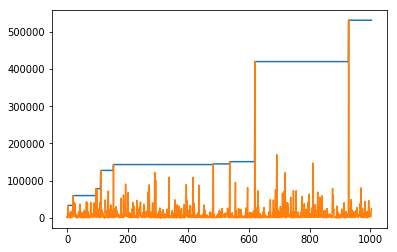

In [33]:
v = []
for i, res in enumerate(optimizer3.res):
    v.append(res['target'])
    
vn = []
for i, val in enumerate(v):
    mv = max(v[0:i+1])
    vn.append(mv)
    
plt.figure()
plt.plot(vn)
plt.plot(v)
plt.show()

In [34]:
df = pd.DataFrame({
    'CFV': v})
df.to_csv('CFV_Iter_4S_RFP.csv')

In [35]:
df = pd.DataFrame({
    'CFV': vn})
df.to_csv('bestCFV_Iter_4S_RFP.csv')

### Check results with plot

In [26]:
inputs = [round(optimizer3.max['params']['IPTG1'], 2)+1e-7, int(optimizer3.max['params']['aTc1'])+1e-7, 
          round(optimizer3.max['params']['IPTG2'], 2)+1e-7, int(optimizer3.max['params']['aTc2'])+1e-7, 
          round(optimizer3.max['params']['IPTG3'], 2)+1e-7, int(optimizer3.max['params']['aTc3'])+1e-7, 
          round(optimizer3.max['params']['IPTG4'], 2)+1e-7, int(optimizer3.max['params']['aTc4'])+1e-7]

ivss = [1,1e-7,1363.193,28.510]
pre = [1,1e-7]
sp = [int(i) for i in list(np.linspace(0,(24*60),5))]
t =  np.linspace(0,(24*60),(24*60)+1)

pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))

# Simulation of the system for the two models and extract of results
solM1 = solveALL(t, pM1, sp, inputs, ivss, pre, 'M1')
solM2 = solveALL(t, pM2, sp, inputs, ivss, pre, 'M2')

RFP_M1 = solM1[:,0:len(pM1[:,1])]
GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]

RFP_M2 = solM2[:,0:len(pM2[:,1])]
GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]


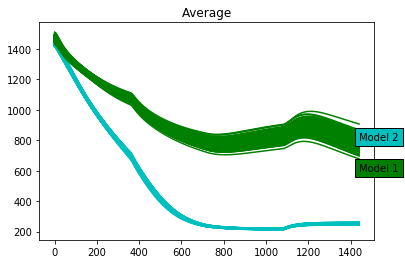

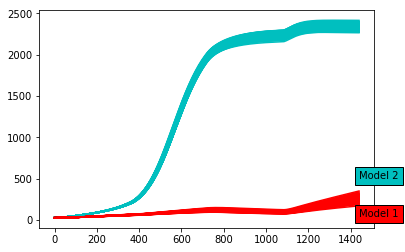

In [27]:
t = np.linspace(0,(24*60),round(24*60/5)+1)

plt.figure()
lines = plt.plot(t, GFP_M2, 'c')
plt.text((24*60)+1, 800, "Model 2", bbox=dict(facecolor='c'))
plt.title("Average")
lines2 = plt.plot(t, GFP_M1, 'g')
plt.text((24*60)+1, 600, "Model 1", bbox=dict(facecolor='g'))

plt.show()
plt.figure()
plt.plot(t, RFP_M2, 'c')

plt.text((24*60)+1, 500, "Model 2", bbox=dict(facecolor='c'))
plt.text((24*60)+1, 40, "Model 1", bbox=dict(facecolor='r'))
plt.plot(t, RFP_M1, 'r')
plt.show()

### Check utility decomposition results

In [ ]:
# Gaussian Process Regression and Reduction

# Means and standard deviations for each time point for each species and for each model
tgp = np.linspace(0,(24*60),(24*60/5)+1)

muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
sdR3 = RFP_M2.std(axis = 1)
muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
sdG3 = GFP_M2.std(axis = 1)
muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
sdR2 = RFP_M1.std(axis = 1)
muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
sdG2 = GFP_M1.std(axis = 1)

# Gaussian Process regression
gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
gR3.findhyperparameters(noruns=15)
gR3.predict(tgp)

gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
gG3.findhyperparameters(noruns=15)
gG3.predict(tgp)

gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
gR2.findhyperparameters(noruns=15)
gR2.predict(tgp)

gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
gG2.findhyperparameters(noruns=15)
gG2.predict(tgp)



In [ ]:
muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
tref = list(tgp[::10])

g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2R3.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
tref = list(tgp[::10])

g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2R2.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
tref = list(tgp[::10])

g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2G3.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
tref = list(tgp[::10])

g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2G2.predict(tref)

In [ ]:
bdR = BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
bdG = BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
u_B = (bdR*bdG)

In [ ]:
print("The BD for RFP is: ", str(bdR))
print("The BD for GFP is: ", str(bdG))
print("The multiplicative BD is: ", str(u_B))
print("The average BD is: ", str((bdR+bdG)/2))